In [1]:
from termcolor import cprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import GridSpec
from os.path import expanduser
from ml_logger import logger
from heapq import heappush, heappop


# Dykstra on the Rope Dataset


First load the pre-computed pair-wise score from the map-reduced chunks: 
 
Copy the `pairwise.npy` numpy file to your `~/fair/pairwise.npy` path.

In [105]:
# np.save(arr=ds, file=expanduser("~/fair/pairwise.npy"))
ds = np.load(file=expanduser("~/fair/pairwise.npy"))

To get the top `k` elements of each row:

In [106]:
import torch
k = 24
with torch.no_grad():
    _ds = torch.tensor(ds)
    _ds[torch.eye(ds.shape[0], dtype=torch.uint8)] = float('inf')
    top_cols, top_col_inds = torch.topk(_ds, k=k, dim=1, largest=False, sorted=True)
print(top_cols.shape)

torch.Size([5600, 24])


In [107]:
rope = np.load(expanduser("~/fair/new_rope_dataset/data/new_rope.npy"))[:10]
all_images = np.concatenate(rope).transpose(0, 3, 1, 2)
traj_labels = np.concatenate([np.ones(len(traj)) * i for i, traj in enumerate(rope)]).astype(int)
traj_starts = [0]
_ds = _ds[:len(all_images), :len(all_images)]
for i in range(len(rope)):
    traj_starts.append(traj_starts[-1] + rope[i].shape[0])
assert len(all_images) == len(_ds), "the dimension of the distance matrix and the images should agree."
cprint('rope dataset is now loaded', "yellow")

rope dataset is now loaded


Now optionally you could load the rope dataset from the same location.

Below we configure the logger to save things locally.

In [108]:
# from plan2vec_experiments import RUN
logger.configure(prefix="plan2vec_experiments/rope", register_experiment=False)
print(rope[0].shape)
print(all_images.shape)
print(traj_starts)

(40, 64, 64, 1)
(5600, 1, 64, 64)
[0, 40, 431, 1059, 1998, 2341, 3056, 3450, 3514, 4638, 5600]


Here is a quick demo of how to visualize the images. But you will not need this, the 
`ds` pairwise distance matrix (loaded earlier) is the only thing you need.

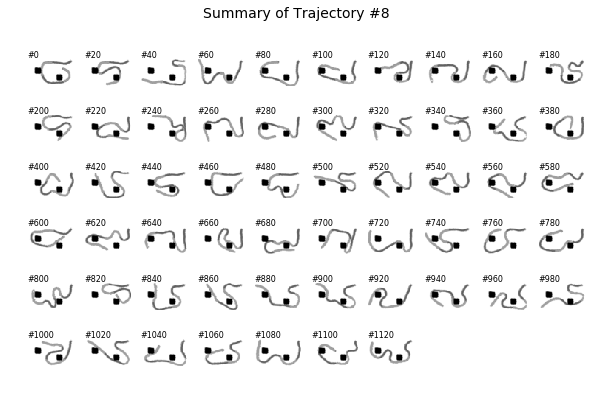

In [109]:
from math import ceil

traj_ind = 8
picked = rope[traj_ind][::20].squeeze(axis=-1)
n_rows = ceil(len(picked) / 10)
fig = plt.figure(figsize=np.array(1.4, dtype=int) * [10, n_rows])
plt.suptitle(f'Summary of Trajectory #{traj_ind}', fontsize=14)
gs = GridSpec(n_rows, 10)
index = 0
for _row in range(n_rows):
    for _col in range(10):
        plt.subplot(gs[_row, _col])
        try:
            plt.imshow(picked[index] , cmap='gray')
            plt.text(0, 10, f"#{index * 20}", fontsize=8)
        except:
            pass
        plt.axis('off')
        index += 1
plt.show();
# logger.savefig(f"figures/traj summary/traj-{traj_ind:02d}.png", dpi=300, bbox_inches="tight")

(5600, 5600)
num_neighbors mean, std 21.68017857142857 17.686749478379838
src:  3868 dest:  1479


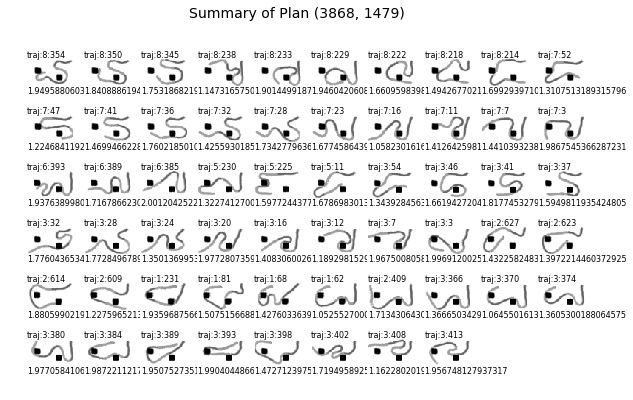

In [123]:
# np.save(arr=top_k, file=expanduser("~/fair/top-k.npy"))
def build_edges(pairwise):
    k = 24
    term_r = 1.
    with torch.no_grad():
        _ds = torch.tensor(pairwise)
        _ds[torch.eye(ds.shape[0], dtype=torch.uint8)] = float('inf')
        for k in range(1, 3):  # add true neighbors
            diag = torch.diagflat(torch.ones(len(_ds) - k, dtype=torch.uint8), k)
            _ds[diag] = 0.5
            diag = torch.diagflat(torch.ones(len(_ds) - k, dtype=torch.uint8), -k)
            _ds[diag] = 0.5
        # top_cols, top_col_inds = torch.topk(_ds, k=k, dim=1, largest=False, sorted=True)
        # # add threshold connection instead.
        full_range = torch.arange(len(_ds))
        inds = [None] * len(_ds)
        for idx, row in enumerate(_ds):
            visited = []
            inds[idx] = full_range[row <= term_r].numpy()
            if len(inds[idx]) == 0:
                raise Exception('term_r too small')
                break
            for i in range(1):
                new_neighbors = [full_range[_ds[id] <= term_r].numpy() for id in inds[idx] if id not in visited]
                if len(new_neighbors) > 0:
                    neighbors = np.concatenate(new_neighbors)
                else:
                    neighbors = []
                visited += list(inds[idx])
                inds[idx] = np.unique(np.concatenate([inds[idx], neighbors]))
                inds[idx] = inds[idx][inds[idx] != idx]  # remove identity
        inds = np.array(inds)
        num_neighbors = [len(i) for i in inds]
        print('num_neighbors mean, std', np.mean(num_neighbors), np.std(num_neighbors))
        top_ds = np.array([row[_] for row, _ in zip(_ds.numpy(), inds)])
    
    edges = dict(enumerate(inds))
    return edges
        
def dijkstras(src, dest, edges):
    visited = set()
    unvisited = []
    distances = {}
    predecessors = {}

    distances[src] = 1
    heappush(unvisited, (1, src))

    while unvisited:
        # visit the neighbors
        dist, v = heappop(unvisited)
        if v in visited or v not in edges:
            continue
        visited.add(v)
        if v == dest:
            # We build the shortest path and display it
            path = []
            pred = v
            while pred != None:
                path.append(pred)
                pred = predecessors.get(pred, None)
            if len(path) == 1:
                print('foo', src == dest)
                print(src)
                print(dest)
                return None, None
            return path[::-1], 1 / dist

        neighbors = list(edges[v])

        for idx, neighbor in enumerate(neighbors):
            if neighbor not in visited:
                new_distance = distances[v]
                if new_distance < distances.get(neighbor, float('inf')):
                    distances[neighbor] = new_distance
                    heappush(unvisited, (new_distance, neighbor))
                    predecessors[neighbor] = v

    # couldn't find a path
    return None, None

# Pick random src and dest
src = np.random.randint(len(all_images))
dest = np.random.randint(len(all_images))
print(ds.shape)
edges = build_edges(ds) 
print('src: ', src, 'dest: ', dest)
path, dist = dijkstras(src, dest, edges)

n_rows = ceil(len(path) / 10)
fig = plt.figure(figsize=np.array(1.4, dtype=int) * [10, n_rows])
plt.suptitle(f'Summary of Plan ({src}, {dest})', fontsize=14)
gs = GridSpec(n_rows, 10)

_row = 0
_col = 0
for idx in range(len(path) - 1):
    if _col >= 10:
        _row += 1
        _col = 0
    plt.subplot(gs[_row, _col])
    plt.imshow(all_images[path[idx]].squeeze(0), cmap='gray')
    traj_ind = traj_labels[path[idx]]
    img_ind = path[idx] - traj_starts[traj_ind]
    plt.text(0, 10, f"traj:{traj_ind}:{img_ind}", fontsize=8)
    plt.text(0, 60, f"{_ds[path[idx], path[idx + 1]]}", fontsize=8)
    plt.axis('off')
    _col += 1
plt.show()

# print(len(path))

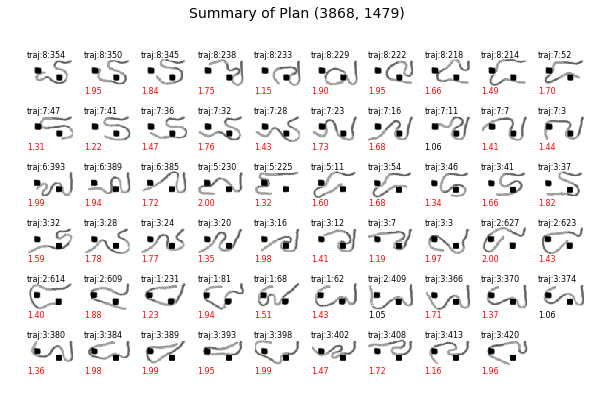

In [124]:
n_rows = ceil(len(path) / 10)
fig = plt.figure(figsize=np.array(1.4, dtype=int) * [10, n_rows])
plt.suptitle(f'Summary of Plan ({src}, {dest})', fontsize=14)
gs = GridSpec(n_rows, 10)

_row = 0
_col = 0
for idx in range(len(path)):
    if _col >= 10:
        _row += 1
        _col = 0
    plt.subplot(gs[_row, _col])
    plt.imshow(all_images[path[idx]].squeeze(0), cmap='gray')
    traj_ind = traj_labels[path[idx]]
    img_ind = path[idx] - traj_starts[traj_ind]
    plt.text(0, 10, f"traj:{traj_ind}:{img_ind}", fontsize=8)
    if idx > 0:
        score = _ds[path[idx - 1], path[idx]]
        plt.text(0, 60, f"{score:0.2f}", fontsize=8, color="red" if score > 1.1 else "black")
    plt.axis('off')
    _col += 1
plt.savefig(f"rope_traj_{src}_{dest}.pdf")